In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Dropout,Convolution2D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization, Activation, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import np_utils
import keras.backend as K
from keras.models import load_model
from scipy.signal import savgol_filter


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/MotionSense

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/MotionSense


## Utils

In [0]:
def create_directories(path):
  """ 
  Checks whether the directory in which the files are to be saved exists,
  if it does not exist, it is created.
  
  Parameters
  ----------
      path: (string)
            The path where folder structure will be made
        
  """
  if not os.path.exists('{}'.format(path)):
    os.makedirs('{}/models'.format(path))
    os.makedirs('{}/images'.format(path))
    os.makedirs('{}/plots'.format(path))

  else:
    print("path already exists")
    
    
def get_batch(data, batch_size):
    """
    Generates a random batch taken from the dataset
    
    Parameters
    ----------
        data: (np.array)
              The n-dimensional dataset from which batches are to be selected
        data: (int)
              The number of batches to be selected

    """
    
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_seqs = data[idx]
    return real_seqs

def sample_image(gan, epoch, X_train, path):
    """
    Generates array of sample images generated by generator model
    
    Parameters
    ----------
        gan:      (XX)
                  Instantiation of GAN or WGAN class
        epoch:    (int)
                  Epoch at which the sample is to be generated. This is passed
                  through by the training loop in the train method of the Trainer
                  class
         X_train: (np.array)
                  Training dataset. This is used to provide a comparison between
                  the generated data, and that from the training set.
    """
    
    
    fig, axarray = plt.subplots(4,1, figsize=(10,12))
    idx = np.random.randint(0, X_train.shape[0])
    
    
    axarray[0].plot(X_train[idx,0,:], c = 'r')
    axarray[0].plot(X_train[idx,1,:], c = 'b')
    axarray[0].plot(X_train[idx,2,:], c = 'g')

    axarray[0].set_title("Training data")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    for i, ax in enumerate(axarray.flatten()):
        if i != 0:
          xx = gan.generate()
          ax.plot(xx[0,0,:], c ='r', label = "acc.x")
          ax.plot(xx[0,1,:], c ='b', label = "acc.y")
          ax.plot(xx[0,2,:], c ='g', label = "acc.z")

          ax.set_title("Generated example {}".format(i))
    plt.savefig('{}/images/sample{}.png'.format(path, epoch), transparent=True)
    plt.close()


## Data Preparation

In [0]:
class DataPreparation:
  
    """
    Object for data extraction, training and test set preparation, and
    feature scaling handling.
    
    The get_ds_infos(), ts() and time_series_to_section() methods have been
    developed from functions in the MotionSense dataset GitHub repository.
    A link to the original code from which it was based is:
    https://github.com/mmalekzadeh/motion-sense/blob/master/codes/gen_paper_codes/1_MotionSense_Trial.ipynb
    
    
    ...


    Methods
    -------
        get_ds_infos:           Inputs: None
                                Loads a .csv file from the MotionSense dataset 
                                containing metadata for the data collection 
                                trials.
                        
         ts:                    Inputs: features, activities
                                'ts' is an abbreviation for timeseries
                                Takes the features and activities which want to 
                                be considered, and generates an array of size
                                len(features) * len(activities) containing data
                                that can be used for training models
                                
        time_series_to_section: Inputs: dataset, num_act_labels, 
                                        sliding_window_size, 
                                        step_size_of_sliding_window, 
                                        standardize,
                                        normalize, 
                                        mode)
                                        
                                Slices array into smaller sections, creating
                                a training set.
                                
        obtain_std_nrm_paras:   Inputs: data_array
                                Abbreviation for obtain standardisation and
                                normalisation parameters.
                                Calculates the mean, std, min and max of data 
                                array along the axis containing the number of features
                                
        standardise:            Inputs: data_array
                                Performs data standardisation ( scaling such 
                                that the scaled data has mean=0 and std=1)
                                along each feature axis.
                                
        normalise:              Inputs: data_array
                                Performs data normalisation ( scaling such 
                                that the scaled data has max=1 and min=1)
                                along each feature axis.
                                
        un_normalise:           Inputs: data_array
                                Reverses the effect of normalise() using only
                                the statistics of the training set as calculated
                                using obtain_std_nrm_pars()
                                
        un_standardise:         Inputs: data_array
                                Reverses the effect of normalise() using only
                                the statistics of the training set as calculated
                                using obtain_std_nrm_pars()

    """

    def __init__(self):
      pass

    def get_ds_infos(self):
      """
      Loads metadata from 'data_subjects_info.csv'
      """

      ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
      dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
      dss = dss[1:]
      print("----> Data subjects information is imported.")
      return dss

    def ts(self, features, activities):

        """ 

        'ts' is an abbreviation for timeseries. Takes the features and activities 
        which want to be considered, and generates an array of size len(features) 
        * len(activities) containing data that can be used for training models
        Parameters
        ----------
            features: (list) 
                      A list containing the string codes for the features under 
                      consideration.
                      e.g. features = ["userAcceleration.x", "userAcceleration.y"]
            activities: (list) 
                      A list containing the string codes for the activities under 
                      consideration.
                      e.g. features = ["dws", "ups", "walk"]

        Returns
        ---------
        train_data , test_data, num_features, num_act_labels
        """

        num_features = len(features)
        num_act_labels = len(activities)
        dataset_columns = num_features+num_act_labels

        label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
        trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5, 13], "std":[6,14]}    

        new = {}

        for requested in trial_codes:
          if requested in act_labels:
            new[requested] = trial_codes[requested]

        trial_codes = new
        label_codes = {}
        count = 0
        for key in trial_codes:
          print(key, trial_codes[key])
          label_codes[key] = num_features + count
          count +=1

        print(label_codes)
        print(trial_codes)
        ds_list = self.get_ds_infos()
        train_data = np.zeros((0,dataset_columns))
        test_data = np.zeros((0,dataset_columns))
        for i, sub_id in enumerate(ds_list[:,0]):
            for j, act in enumerate(trial_codes):
                for trial in trial_codes[act]:
                    fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                    print("Loading: ", fname)
                    raw_data = pd.read_csv(fname)
                    raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                    raw_data = raw_data[features]
                    unlabel_data = raw_data.values

                    label_data = np.zeros((len(unlabel_data), dataset_columns))
                    label_data[:,:-(num_act_labels )] = unlabel_data
                    label_data[:,label_codes[act]] = 1
                    if trial > 10:
                        test_data = np.append(test_data, label_data, axis = 0)
                    else:    
                        train_data = np.append(train_data, label_data, axis = 0)

        return train_data , test_data, num_features, num_act_labels

    def time_series_to_section(self, dataset, num_act_labels, sliding_window_size, step_size_of_sliding_window, standardize = True, normalize = False, mode="Test"):
        """ 
        The dataset generated by ts() is sliced into smaller windows to generate a training set.
        This is returned alongside an array of 'one-hot' embedded vectors,containing the label which
        corresponds to the activity carried out during each window.

        Parameters
        ----------
            dataset:                      (array)    
                                          Dataset generated by the ts() function
                                          This is seperated into activities but
                                          not yet sliced into smaller windows
            num_act_labels:               (int)
                                          The number of activities being considered
                                          This is also return from ts()
            sliding_window_size:          (int)
                                          The size of the interval in number of
                                          timesteps. A value of 200 is recommended
                                          as this corresponds to 4 seconds
            step_size_of_sliding_window:  (int)
                                          Determines stride of sliding window as it
                                          slices the dataset
            standardize:                  (bool)
                                          Will standardise the dataset if True
            normalize:                    (bool)
                                          Will normalise the dataset if True
            mode:                         (str)
                                          Only if the mode=="Test", the parameters
                                          for the feature scaling will be stored

        Returns
        --------

        """

        data = dataset[: , 0:-(num_act_labels)]
        act_labels = dataset[: , -(num_act_labels):]


        if mode == "Train":
          self.obtain_std_nrm_paras(data)
        standardised_data = self.standardise(data)
        normalised_data = self.normalise(data)


        if normalize:

            data = normalised_data
            print("data has been normalised")

        elif standardize:
            data = standardised_data
            print("data has been standardised")
        else:
            print("----> Without Standardisation or Normalisation.....")

        ## We want the Rows of matrices show each Feature and the Columns show time points.
        data = data.T

        size_features = data.shape[0]
        size_data = data.shape[1]
        number_of_secs = round(((size_data - sliding_window_size)/step_size_of_sliding_window))

        ##  Create a 3D matrix for Storing Snapshots  
        secs_data = np.zeros((number_of_secs , size_features , sliding_window_size ))
        act_secs_labels = np.zeros((number_of_secs, num_act_labels))

        k=0    
        for i in range(0 ,(size_data)-sliding_window_size  , step_size_of_sliding_window):
            j = i // step_size_of_sliding_window
            if(j>=number_of_secs):
                break
            if(not (act_labels[i] == act_labels[i+sliding_window_size-1]).all()): 
                continue    
            secs_data[k] = data[0:size_features, i:i+sliding_window_size]
            act_secs_labels[k] = act_labels[i].astype(int)
            k = k+1
        secs_data = secs_data[0:k]
        act_secs_labels = act_secs_labels[0:k]

        return secs_data, act_secs_labels


    def obtain_std_nrm_paras(self, data):

      """
      Abbreviation for obtain standardisation and normalisation parameters. 
      Calculates the mean, std, min and max of data array along the axis 
      containing the number of features. It stores these values as
      attributes of the class so that they can be used to reverse the effects
      of normalisation and standardisation
      """

      means, stds = [], []
      mins, maxs = [], []

      for i in range(data.shape[1]):
        min_, max_ = np.min(data[:,i]), np.max(data[:,i])
        mean, std = np.mean(data[:,i], dtype=np.float64), np.std(data[:,i], dtype=np.float64)

        mins.append(min_)
        maxs.append(max_)

        means.append(mean)
        stds.append(std)

        self.standardise_params = [means, stds]
        self.normalise_params = [mins, maxs]


    def normalise(self,data):
      """
      Performs data normalisation (scaling such that the scaled data has max=1 
      and min=1) along each feature axis.
      """
      mins, maxs = self.normalise_params

      normalised = np.zeros((data.shape))
      for i in range(data.shape[1]):
        print(i)
        normalised[:,i] = (2 * (data[:,i] - mins[i])/(maxs[i] - mins[i])) -1


      return normalised

    def standardise(self,data):
      """
      Performs data standardisation ( scaling such that the scaled data has 
      mean=0 and std=1) along each feature axis. 
      """

      means, stds = self.standardise_params

      standardised = np.zeros((data.shape))
      for i in range(data.shape[1]):
        standardised[:,i] = (data[:,i] - means[i])/stds[i]

      return standardised


    def un_normalise(self, normalised_data):
      """
      Reverses the effect of normalise() using only the statistics of the training 
      set as calculated using obtain_std_nrm_pars()
      """
      mins, maxs = self.normalise_params
      print(mins,maxs)
      unnormalised = np.zeros((normalised_data.shape))

      for i in range(normalised_data.shape[1]):
        unnormalised[:,i] = (normalised_data[:,i] +1)/2 * (maxs[i] - mins[i]) + mins[i]

      return unnormalised


    def un_standardise(self, standardised_data):
      """
      Reverses the effect of standardise() using only the statistics of the training 
      set as calculated using obtain_std_nrm_pars()
      """
      means, stds = self.standardise_params

      unstandardised = np.zeros((standardised_data.shape))
      print(unstandardised.shape)
      for i in range(standardised_data.shape[1]):
        unstandardised[:,i] = (standardised_data[:,i] * stds[i]) +  means[i]

      return unstandardised

      
  


## Trainer

In [0]:
class Trainer():
  def __init__(self, model, PATH, duration):
    self.model = model
    self.disc_loss = []

    self.disc_loss_r = []
    self.disc_loss_f = []
    
    self.crit_loss_r = []
    self.crit_loss_f = []

    self.crit_loss = []
    self.gen_loss = []
    self.path = PATH
    self.duration = duration
    
  def train_wgan(self, epochs, batch_size, sample_interval, train_data):

    
    # Create labels for real and fake data
    real = np.ones((batch_size, 1))
    fake = -np.ones((batch_size, 1))

    for epoch in range(epochs):
        for _ in range(self.model.n_critic):

          real_seqs = get_batch(train_data, batch_size)
          noise = np.random.normal(0, 1, (batch_size, self.model.latent_dim))

          # Generate a batch of new note sequences
          gen_seqs = self.model.generator.predict(noise)

          # Train the discriminator
          c_loss_real = self.model.critic.train_on_batch(real_seqs, real)
          c_loss_fake = self.model.critic.train_on_batch(gen_seqs, fake)


          # Clip critic weights
          for l in self.model.critic.layers:
              weights = l.get_weights()
              weights = [np.clip(w, -self.model.clip_value, self.model.clip_value) for w in weights]
              l.set_weights(weights)

        noise = np.random.normal(0, 1, (batch_size, self.model.latent_dim))

        # Train the generator (to have the discriminator label samples as real)
        g_loss = self.model.wgan.train_on_batch(noise, real)

        if epoch % sample_interval == 0:
          print ("%d [CritLoss(Real): %10f] [CritLoss(Fake): %10f] [GenLoss = %10f]" % (epoch, c_loss_real[0], c_loss_fake[0], 100*g_loss))

          self.crit_loss_r.append(c_loss_real)
          self.crit_loss_f.append(c_loss_fake)
          self.gen_loss.append(g_loss)
          sample_image(self.model, epoch, real_seqs, self.path)
        if (epoch % 1000 == 0):
          self.save_models(self.path, epoch, self.model.generator, self.model.critic)
    
    self.savedata(self.path, train_data)
    self.showLoss(self.path, save=True)
  
       
  def train_gan(self, epochs, batch_size, sample_interval, train_data):

    
    # Create labels for real and fake data
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # Get batch of real data
        real_seqs = get_batch(train_data, batch_size)
        # Generate batch of fake data using random noise
        noise = np.random.normal(0, 1, (batch_size, self.model.latent_dim))
        gen_seqs = self.model.generator.predict(noise)

        # Train the discriminator to accept real data and reject fake data
        d_loss_real = self.model.discriminator.train_on_batch(real_seqs, real)
        d_loss_fake = self.model.discriminator.train_on_batch(gen_seqs, fake)


        # Train the generator such that when it takes random noise as an
        # input, it will produce fake data which the discriminator accepts
        # as real

        noise = np.random.normal(0, 1, (batch_size, self.model.latent_dim))
        g_loss = self.model.gan.train_on_batch(noise, real)

        if epoch % sample_interval == 0:
          print ("%d [DiscLoss/Acc Real: (%10f, %10f)] [DiscLoss/Acc Fake: (%10f, %10f)] [DiscAcc %10f][GenLoss = %10f]" % (epoch,
                                                                                                             d_loss_real[0], d_loss_real[1], 
                                                                                                             d_loss_fake[0], d_loss_fake[1], 
                                                                                                             0.5 * (d_loss_real[1] + d_loss_fake[1]), 
                                                                                                             g_loss))

          self.disc_loss_r.append(d_loss_real)
          self.disc_loss_f.append(d_loss_fake)

          self.gen_loss.append(g_loss)
          sample_image(self.model, epoch, real_seqs, self.path)
        if (epoch % 1000 == 0):
          self.save_models(self.path, epoch, self.model.generator, self.model.discriminator)
    
    self.savedata(self.path, train_data)
    self.showLoss(self.path, save=True)
    
  def save_models(self, path, epoch, generator, discriminator=None,  critic=None):
      generator.save('{}/models/generator_{}.h5'.format(path, epoch))
      
      if discriminator:
        discriminator.save('{}/models/discriminator_{}.h5'.format(path, epoch))
      if critic:
        critic.save('{}/models/critic_{}.h5'.format(path, epoch))
      
  def savedata(self, path, train_set):
      print("saving")
      fn1 = path + "/gen_loss.npy"
      
      fn2 = path + "/disc_loss_r.npy"
      fn3 = path + "/disc_loss_f.npy"
      
      fn4 = path + "/crit_loss_r.npy"
      fn5 = path + "/crit_loss_f.npy"

      

      np.save(fn1, self.gen_loss)
      
      np.save(fn2, self.disc_loss_r)
      np.save(fn3, self.disc_loss_f)
      
      np.save(fn4, self.crit_loss_r)
      np.save(fn5, self.crit_loss_f)



      
  def showLoss(self, path, save=True):
    onRealLoss =  np.array(self.disc_loss_r)[:, 0]
    onRealAcc  =  np.array(self.disc_loss_r)[:, 1]

    onFakeLoss =  np.array(self.disc_loss_f)[:, 0]
    onFakeAcc  =  np.array(self.disc_loss_f)[:, 1]

    g_Loss = np.array(self.gen_loss)
    plt.figure(figsize = (8,5.5), dpi=100)

    plt.title("Discriminator and Generated Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.plot([-10,1010], [np.log(2), np.log(2)], '-', label="Expected value (log 2)", c= 'k', lw=3)

    plt.plot(savgol_filter(onRealLoss,11,1), label="Discriminator on Real", c='g')
    plt.plot(savgol_filter(onFakeLoss,11,1), label="Discriminator on Fake", c='r')
    plt.plot(savgol_filter(g_Loss,15,1), label="Generator", c='b')
    plt.grid()
    plt.legend()

    if save==True:
      plt.savefig(path + "/plots/Losses.png", edgecolor='k', dpi=100)


    plt.figure(figsize = (8,6), dpi=100)
    plt.title("Accuracy of Discriminator in Correctly Identifying Real and Fake samples")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.plot(savgol_filter(onFakeAcc,51,3), label="Fake", c='r')
    plt.plot(savgol_filter(onRealAcc,51,3), label="Real", c='g')
    plt.plot([-10,1010], [0.5,0.5], '-', label="Expected value (0.5)", c= 'k', lw=3)
    plt.grid()
    plt.legend()
    if save==True:
      plt.savefig(path + "/plots/Accuracies.png", edgecolor='k', dpi=100)


In [0]:
class WGAN():
    def __init__(self, rows):
        self.gan = None
        
        ### Generator
        self.generator = None
        self.generator_optimizer = RMSprop(lr=0.00005)
        
        ### Discriminator
        self.critic = None
        self.critic_optimizer = RMSprop(lr=0.00005)
        
        
        self.channels = 3
        self.seq_length = rows
        self.seq_shape = (self.channels, self.seq_length)
        self.latent_dim = 100
        self.disc_loss = []
        self.disc_loss2 = []
        self.gen_loss =[]
        
        self.n_critic = 3
        self.clip_value = 0.024775

        ### Build network
        self.critic = self.build_critic()

        self.generator = self.build_generator()
    
        self.wgan = self.build_wgan()

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_wgan(self):
        self.critic.trainable = False
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        validity = self.critic(generated_seq)

        model = Model(z, validity)
        model.compile(loss=self.wasserstein_loss, optimizer=self.generator_optimizer)
        
        return model
        

    def build_critic(self):
        num_train, height, width, channel = train_data.shape

        
        ## MTCNN
        kernel_size_1 = 5
        kernel_size_2 = 3
        pool_size_1 = 2
        pool_size_2 = 3  
        conv_depth_1 = 50 
        conv_depth_2 = 40 
        conv_depth_3 = 20 
        drop_prob_1 = 0.2 
        drop_prob_2 = 0.4 
        hidden_size = 400 

        model = Sequential()
        model.add(Convolution2D(conv_depth_1, (1 , kernel_size_1), padding='valid', activation='relu', input_shape=(height, width,1)))
        model.add(Convolution2D(conv_depth_1, (1 , kernel_size_2), padding='same', activation='relu'))
        model.add(Dense(int(conv_depth_1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(1, pool_size_1)))
        model.add(Dropout(drop_prob_1))

        model.add(Convolution2D(conv_depth_2, (1 , kernel_size_1), padding='valid', activation='relu'))
        model.add(Dense(conv_depth_2, activation='relu'))
        model.add(MaxPooling2D(pool_size=(1, pool_size_2)))
        model.add(Dropout(drop_prob_1))

        model.add(Convolution2D(conv_depth_3, (1 , kernel_size_2), padding='valid', activation='relu'))
        model.add(Dropout(drop_prob_1))

        model.add(Flatten())
        model.add(Dense((hidden_size), activation='relu'))
        model.add(Dropout(drop_prob_2))
        
        model.add(Dense(1))
        model.summary()
        model.compile(loss=self.wasserstein_loss, optimizer=self.critic_optimizer, metrics=['accuracy'])
  

        return model
      
    def build_generator(self):
        model = Sequential()
        model.add(Dense(1024, input_dim=self.latent_dim,))
        model.add(Activation('tanh'))
        model.add(Dense(128*3*20))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Reshape((3, 20, 128), input_shape=(128*7*7,)))
        model.add(UpSampling2D(size=(1, 5)))
        model.add(Convolution2D(64, (1, 3), padding='same'))
        model.add(Activation('tanh'))
        model.add(UpSampling2D(size=(1,2)))
        model.add(Convolution2D(1, (1, 5), padding='same'))
        model.add(Activation('tanh'))
        return model

        
    def generate(self):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        return predictions


## GAN

In [0]:
class GAN():
    def __init__(self, rows):
        self.gan = None
        
        ### Generator
        self.generator = None
        self.generator_optimizer = Adam(0.0002, 0.9)
        
        ### Discriminator
        self.discriminator = None
        self.discriminator_optimizer = SGD(lr=0.012)
        
        
        self.channels = 3
        self.length = rows
        self.shape = (self.channels, self.length)
        self.latent_dim = 100
        self.disc_loss = []
        self.disc_loss2 = []
        self.gen_loss =[]
        

        ### Build network
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()
        self.gan = self.build_gan()

        
    def build_gan(self):
        self.discriminator.trainable = False
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        validity = self.discriminator(generated_seq)

        model = Model(z, validity)
        model.compile(loss='binary_crossentropy', optimizer=self.generator_optimizer)
        
        return model
        

    def build_discriminator(self):
        num_train, height, width, channel = train_data.shape
        
        ## MTCNN
        kernel_size_1 = 5
        kernel_size_2 = 3
        pool_size_1 = 2
        pool_size_2 = 3  
        conv_depth_1 = 50 
        conv_depth_2 = 40 
        conv_depth_3 = 20 
        drop_prob_1 = 0.2 
        drop_prob_2 = 0.4 
        hidden_size = 400 

        model = Sequential()
        model.add(Convolution2D(conv_depth_1, (1 , kernel_size_1), padding='valid', activation='relu', input_shape=(height, width,1)))
        model.add(Convolution2D(conv_depth_1, (1 , kernel_size_2), padding='same', activation='relu'))
        model.add(Dense(int(conv_depth_1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(1, pool_size_1)))
        model.add(Dropout(drop_prob_1))

        model.add(Convolution2D(conv_depth_2, (1 , kernel_size_1), padding='valid', activation='relu'))
        model.add(Dense(conv_depth_2, activation='relu'))
        model.add(MaxPooling2D(pool_size=(1, pool_size_2)))
        model.add(Dropout(drop_prob_1))

        model.add(Convolution2D(conv_depth_3, (1 , kernel_size_2), padding='valid', activation='relu'))
        model.add(Dropout(drop_prob_1))

        model.add(Flatten())
        model.add(Dense((hidden_size), activation='relu'))
        model.add(Dropout(drop_prob_2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer=self.discriminator_optimizer, metrics=['accuracy'])
  

        return model
      
    def build_generator(self):
        model = Sequential()
        model.add(Dense(1024, input_dim=self.latent_dim,))
        model.add(Activation('tanh'))
        model.add(Dense(128*3*20))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Reshape((3, 20, 128), input_shape=(128*7*7,)))
        model.add(UpSampling2D(size=(1, 5)))
        model.add(Convolution2D(64, (1, 3), padding='same'))
        model.add(Activation('tanh'))
        model.add(UpSampling2D(size=(1,2)))
        model.add(Convolution2D(1, (1, 5), padding='same'))
        model.add(Activation('tanh'))
        return model

        
    def generate(self):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        return predictions


## main

In [0]:
features = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]#, "rotationRate.x", "rotationRate.y", "rotationRate.z"]
# act_labels = ["dws","ups"]#,"wlk", "jog"]#, "sit", "std"]
act_labels = ["dws"]


Loader = DataPreparation()
train_ts, test_ts,num_features, num_act_labels = Loader.ts(features, act_labels)





train_data3, act_train_labels= Loader.time_series_to_section(train_ts.copy(),
                                                             num_act_labels,
                                                             sliding_window_size=200,
                                                             step_size_of_sliding_window=10,
                                                             standardize = False,
                                                             normalize = True,
                                                             mode="Train")

test_data, act_test_labels = Loader.time_series_to_section(test_ts.copy(),
                                                            num_act_labels,
                                                            sliding_window_size=200,
                                                            step_size_of_sliding_window=10,
                                                            standardize = False,
                                                            normalize = True,
                                                            mode="Test")
train_data = np.expand_dims(train_data,axis=3)
test_data = np.expand_dims(test_data,axis=3)


print("--> Shape of Training Sections:", train_data.shape)
print("--> Shape of Test Sections:", test_data.shape)




## run

path already exists
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 3, 196, 50)        300       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 3, 196, 50)        7550      
_________________________________________________________________
dense_97 (Dense)             (None, 3, 196, 50)        2550      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 98, 50)         0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 3, 98, 50)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 3, 94, 40)         10040     
_________________________________________________________________
dense_98 (Dense)             (Non

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [DiscLoss/Acc Real: (  0.695850,   0.437500)] [DiscLoss/Acc Fake: (  0.698069,   0.312500)] [DiscAcc   0.375000][GenLoss =   0.697359]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [DiscLoss/Acc Real: (  0.695828,   0.375000)] [DiscLoss/Acc Fake: (  0.681353,   0.671875)] [DiscAcc   0.523438][GenLoss =   0.716056]
20 [DiscLoss/Acc Real: (  0.694488,   0.531250)] [DiscLoss/Acc Fake: (  0.668299,   0.812500)] [DiscAcc   0.671875][GenLoss =   0.734454]
30 [DiscLoss/Acc Real: (  0.697727,   0.437500)] [DiscLoss/Acc Fake: (  0.660209,   0.937500)] [DiscAcc   0.687500][GenLoss =   0.747206]
40 [DiscLoss/Acc Real: (  0.698330,   0.390625)] [DiscLoss/Acc Fake: (  0.660046,   0.937500)] [DiscAcc   0.664062][GenLoss =   0.751135]
50 [DiscLoss/Acc Real: (  0.688554,   0.625000)] [DiscLoss/Acc Fake: (  0.666040,   0.906250)] [DiscAcc   0.765625][GenLoss =   0.750590]
60 [DiscLoss/Acc Real: (  0.671674,   0.765625)] [DiscLoss/Acc Fake: (  0.669550,   0.828125)] [DiscAcc   0.796875][GenLoss =   0.748874]
70 [DiscLoss/Acc Real: (  0.644375,   0.906250)] [DiscLoss/Acc Fake: (  0.672200,   0.750000)] [DiscAcc   0.828125][GenLoss =   0.749994]
80 [DiscLoss/Acc Real: (  0.617381

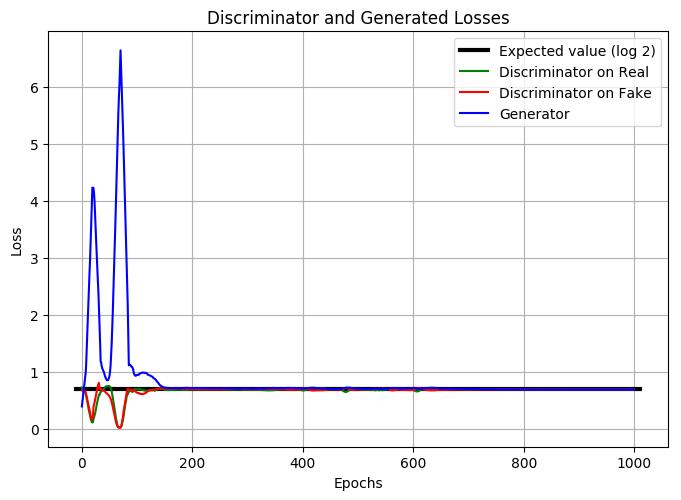

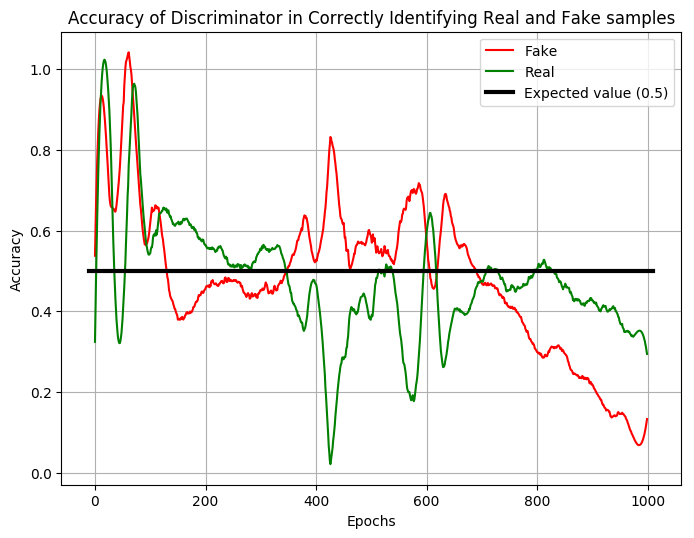

In [42]:
length = 200
expt_name = "dws"

create_directories(expt_name)
gan_ = GAN(length)
trainer_ = Trainer(gan_, expt_name, length)
trainer_.train_gan(epochs=10000, batch_size=64, sample_interval=10, train_data=train_data)

In [0]:
predictions.shape

(1, 3, 200, 1)